In [ ]:
"""
Synthetic time series data generation module

This module provides functionality to generate synthetic time series data using the SARIMA (Seasonal Autoregressive Integrated Moving Average) model, and to simulate concept drift by mixing multiple processes.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from dataclasses import dataclass, field
from typing import List, Optional, Tuple
import dataclasses

np.random.seed(42)

# =============================================================================
# --- 1. Process configuration class ---
# =============================================================================

@dataclass
class ProcessConfig:
	"""
	Class to hold the configuration of a time series process based on the SARIMA model

	SARIMA model: SARIMA(p,d,q)(P,D,Q)s
	- (p,d,q): Non-seasonal components - AR order, differencing order, MA order
	- (P,D,Q)s: Seasonal components - seasonal AR order, seasonal differencing order, seasonal MA order, seasonal period

	Attributes:
		name (str): Process name (e.g., "Process A")

		n_samples (int): Number of samples to generate (time series length)

		ar_params (List[float]): List of AR (autoregressive) parameters
			- Length determines AR order p
			- Each value represents the dependence on past values (range: -1 < φ < 1 is desirable)
			- Example: [0.7] → 1st order AR, dependent on previous value with weight 0.7
			- Example: [0.5, 0.3] → 2nd order AR, dependent on 1st order previous value with weight 0.5 and 2nd order previous value with weight 0.3

		d (int): Differencing order (non-seasonal)
			- 0: Stationary process (no differencing)
			- 1: 1st order differencing (trend removal, random walk)
			- 2 or more: Higher order differencing (rare, usually up to 1)

		ma_params (List[float]): List of MA (moving average) parameters
			- Length determines MA order q
			- Each value represents the dependence on past noise terms
			- Example: [0.2] → 1st order MA, dependent on previous noise with weight 0.2
			- Example: [-0.3, 0.5] → 2nd order MA, negative values are also possible

		seasonal_ar_params (List[float]): List of seasonal AR parameters
			- Length determines seasonal AR order P
			- Each value represents the dependence on past values (e.g., for weekly data with s=7, 1 week ago)
			- Example: [0.8] → dependent on 1 seasonal period ago with weight 0.8

		D (int): Seasonal differencing order
			- 0: No seasonal trend
			- 1: Seasonal differencing (e.g., current month - same month last year)
			- Used for removing seasonal patterns

		seasonal_ma_params (List[float]): List of seasonal MA parameters
			- Length determines seasonal MA order Q
			- Each value represents the dependence on past noise terms
			- Example: [0.2] → 1st order MA, dependent on previous noise with weight 0.2
			- Example: [-0.3, 0.5] → 2nd order MA, negative values are also possible

		s (int): Seasonal period
			- 0: No seasonal pattern
			- 7: Weekly pattern (for daily data)
			- 12: Annual pattern (for monthly data)
			- 24: Daily pattern (for hourly data)

		noise_std (float): Standard deviation of white noise
			- Controls the size of the random component
			- Larger values increase irregularity
			- Default: 1.0

	Example:
		# Simple AR(1) process
		ProcessConfig(name="AR1", n_samples=1000, ar_params=[0.7])

		# ARMA(1,1) process
		ProcessConfig(name="ARMA", n_samples=1000, ar_params=[0.5], ma_params=[0.3])

		# SARIMA process with weekly seasonal pattern
		ProcessConfig(name="Weekly", n_samples=1000, ar_params=[0.7],
					 seasonal_ar_params=[0.8], D=1, s=7)
	"""
	name: str
	n_samples: int = 0
	ar_params: List[float] = field(default_factory=list)
	d: int = 0
	ma_params: List[float] = field(default_factory=list)
	seasonal_ar_params: List[float] = field(default_factory=list)
	D: int = 0
	seasonal_ma_params: List[float] = field(default_factory=list)
	s: int = 0
	noise_std: float = 1.0


# =============================================================================
# --- 2. Generator class ---
# =============================================================================

class TimeSeriesGenerator:
	"""
	Class to generate SARIMA time series data based on ProcessConfig
	Uses the SARIMAX model from statsmodels to perform simulation
	"""

	def __init__(self, config: ProcessConfig):
		"""
		Constructor

		Args:
			config (ProcessConfig): Time series process configuration
		"""
		self.config = config

	def generate(self) -> np.ndarray:
		"""
		Generate time series data based on the configuration

		Returns:
			np.ndarray: Generated time series data (length: config.n_samples)
		"""
		cfg = self.config

		# SARIMA order settings: (p, d, q)
		# p = AR order (length of ar_params)
		# d = differencing order
		# q = MA order (length of ma_params)
		order = (len(cfg.ar_params), cfg.d, len(cfg.ma_params))

		# Seasonal order settings: (P, D, Q, s)
		# P = seasonal AR order
		# D = seasonal differencing order
		# Q = seasonal MA order
		# s = seasonal period
		seasonal_order = (len(cfg.seasonal_ar_params), cfg.D, len(cfg.seasonal_ma_params), cfg.s)

		# Initialize SARIMAX model
		# Initialize with dummy data (zero array) and perform simulation later
		model = SARIMAX(np.zeros(cfg.n_samples), order=order, seasonal_order=seasonal_order)

		# Build parameter vector
		# Order: [AR coefficients, MA coefficients, seasonal AR coefficients, seasonal MA coefficients, noise variance]
		params = np.r_[
			cfg.ar_params,           # φ1, φ2, ...
			cfg.ma_params,           # θ1, θ2, ...
			cfg.seasonal_ar_params,  # Φ1, Φ2, ...
			cfg.seasonal_ma_params,  # Θ1, Θ2, ...
			cfg.noise_std**2         # σ² (variance)
		]

		# Time series simulation
		# nsimulations: number of samples to generate
		# burn: initial burn-in period (discarded)
		return model.simulate(params, nsimulations=cfg.n_samples, burn=500)


# =============================================================================
# --- 3. Mixing segment configuration class ---
# =============================================================================

@dataclass
class MixingSegmentConfig:
	"""
	Class to hold the configuration of a time series mixing segment

	Defines the configuration for mixing multiple base processes with weights
	Used for concept drift simulation

	Attributes:
		name (str): Segment name (e.g., "Train", "Drift to B")

		length (int): Time series length (number of samples) for this segment
			- Each segment length can be set independently
			- Example: Train period=1000, Test period=500, Drift period=1000

		weights (List[float]): Weights for each base process
			- Length must match the number of base processes
			- Does not need to sum to 1.0 (no automatic normalization)
			- Example: [0.8, 0.2, 0.0] → Process A: 80%, Process B: 20%, Process C: 0%
			- Example: [0.0, 1.0, 0.0] → Only Process B (sudden drift)
			- Example: [0.33, 0.33, 0.34] → Equal mixing

	Example:
		# Train period (Process A dominates)
		MixingSegmentConfig(name="Train", length=1000, weights=[0.9, 0.1, 0.0])

		# Drift period (transition to Process B)
		MixingSegmentConfig(name="Drift", length=500, weights=[0.2, 0.7, 0.1])

		# Regression period (return to Process A)
		MixingSegmentConfig(name="Return", length=500, weights=[0.8, 0.1, 0.1])
	"""
	name: str
	length: int
	weights: List[float]


# =============================================================================
# --- 4. Time series mixing function ---
# =============================================================================

def create_mixed_stream(
	base_configs: List[ProcessConfig],
	mixing_plan: List[MixingSegmentConfig]
) -> Tuple[np.ndarray, np.ndarray]:
	"""
	Generate a mixed stream by generating multiple independent time series processes, normalizing them, and mixing them

	This function performs the following processing:
	1. Generate a complete time series for each base process
	2. Standardize each time series (mean=0, std=1)
	3. Mix each segment according to the mixing plan
	4. Combine all segments to create the final data stream

	Args:
		base_configs (List[ProcessConfig]): List of base process configurations
			- Each element defines an independent time series process
			- n_samples is automatically overwritten to the total length
			- Example: [ProcessA, ProcessB, ProcessC] → 3 different processes with different characteristics

		mixing_plan (List[MixingSegmentConfig]): Mixing plan (list of segments)
			- Divide the entire time series into multiple segments
			- Set different mixing ratios for each segment
			- The total length of the segments equals the final time series length
			- Example: [Train period, Test period, Drift period 1, Drift period 2, ...]

	Returns:
		Tuple[np.ndarray, np.ndarray]: (mixed stream, normalized base series array)
			- First element: Mixed time series data (1D array, length=total length of all segments)
			- Second element: Normalized base series (2D array, shape=[n_bases, total_length])

	Details:
		Normalization: Standardize each base series by z = (x - μ) / σ
			- μ: mean
			- σ: standard deviation (minimum value 1e-8 to avoid division by zero)

		Mixing: Calculate mixed = Σ(weight_i × base_i) for each segment
			- Weights are not normalized, so be careful about the total value

	Exception:
		AssertionError: If the length of the segment weight list does not match the number of base processes

	Example:
		>>> base_A = ProcessConfig(name="A", n_samples=0, ar_params=[0.7])
		>>> base_B = ProcessConfig(name="B", n_samples=0, ar_params=[0.5], d=1)
		>>> plan = [
		...     MixingSegmentConfig("Train", length=1000, weights=[0.8, 0.2]),
		...     MixingSegmentConfig("Test", length=500, weights=[0.2, 0.8])
		... ]
		>>> stream, bases = create_mixed_stream([base_A, base_B], plan)
		>>> stream.shape  # (1500,)
		>>> bases.shape   # (2, 1500)
	"""
	num_bases = len(base_configs)
	total_length = sum(segment.length for segment in mixing_plan)

	# ========== Step 1: Generate base time series ==========
	# Generate time series of full length based on each process configuration
	base_series_list = []
	print("Generating base time series...")
	for i, base_config in enumerate(base_configs):
		# Overwrite n_samples to the total length (ignore the original setting)
		full_length_config = dataclasses.replace(base_config, n_samples=total_length)
		generator = TimeSeriesGenerator(full_length_config)
		base_series_list.append(generator.generate())
		print(f"  - Generated base series '{base_config.name}' (length={total_length})")

	# ========== Step 2: Normalization processing ==========
	# Standardize each base series to mean=0, std=1
	# This allows fair mixing of processes with different scales
	print("\nNormalizing base series (mean=0, std=1)...")
	normalized_base_series_list = []
	for idx, series in enumerate(base_series_list):
		mean = np.mean(series)
		std = np.std(series)
		if std < 1e-8:
			print(f"  Warning: Base series {idx} has very small std ({std:.2e}), setting to 1.0")
			std = 1.0
		normalized_series = (series - mean) / std
		normalized_base_series_list.append(normalized_series)
		print(f"  - Normalized series {idx}: mean={mean:.3f}, std={std:.3f}")

	# ========== Step 3: Mixing by segment ==========
	# Mix each segment according to the mixing plan
	stream_segments = []
	current_pos = 0
	print("\nMixing normalized segments according to the plan...")

	for segment_config in mixing_plan:
		# Check if the number of weights matches the number of base processes
		assert len(segment_config.weights) == num_bases, \
			f"Weights length ({len(segment_config.weights)}) must match number of base processes ({num_bases})"

		# Calculate the start and end positions of the current segment
		start, end = current_pos, current_pos + segment_config.length

		# Mixing by weighted addition
		# mixed[t] = w1*base1[t] + w2*base2[t] + ... + wn*basen[t]
		mixed_segment = np.zeros(segment_config.length)
		for i in range(num_bases):
			weight = segment_config.weights[i]
			base_segment = normalized_base_series_list[i][start:end]
			mixed_segment += weight * base_segment

		stream_segments.append(mixed_segment)
		current_pos = end
		print(f"  - Created segment '{segment_config.name}' "
			  f"(length={segment_config.length}, weights={segment_config.weights})")

	# ========== Step 4: Combine all segments ==========
	# Combine all segments in the time series direction
	final_stream = np.concatenate(stream_segments)

	print(f"\nFinal stream created: total length = {len(final_stream)}")

	# Return the normalized base series for visualization
	return final_stream, np.array(normalized_base_series_list)


# =============================================================================
# --- 5. Visualization function ---
# =============================================================================

def plot_mixed_stream(
	stream: np.ndarray,
	base_series: np.ndarray,
	mixing_plan: List[MixingSegmentConfig]
) -> None:
	"""
	Visualize the mixed data stream and base processes
	This function displays the following elements in one graph:
	- Time series of each base process (thin line)
	- Final mixed stream (thick black line)
	- Range of each segment (colored background)

	Args:
		stream (np.ndarray): Mixed final time series data
			- Shape: (total_length,)

		base_series (np.ndarray): Normalized base series
			- Shape: (n_bases, total_length)
			- Each row corresponds to one base process

		mixing_plan (List[MixingSegmentConfig]): Mixing plan
			- Used for displaying segment boundaries and weights
	"""
	# Initialize the figure (horizontal layout)
	plt.figure(figsize=(18, 7))

	# ========== Plot base processes ==========
	# Plot each base series with a thin line
	for i, base in enumerate(base_series):
		label = f'Base Process {chr(65+i)} (Normalized)'  # A, B, C, ...
		plt.plot(base, alpha=0.3, linestyle='--', label=label)

	# ========== Plot mixed stream ==========
	# Highlight the final mixed result with a thick black line
	plt.plot(stream, label="Final Mixed Stream", color='black', linewidth=2.0)

	# ========== Visualize segment boundaries ==========
	# Display the range of each segment with a colored background
	current_pos = 0
	for segment in mixing_plan:
		start, end = current_pos, current_pos + segment.length

		# Draw a colored band in the vertical direction
		# Set alpha=0.15 for semi-transparency
		# Assign a random color to each segment
		segment_label = f"{segment.name}: {segment.weights}"
		plt.axvspan(start, end, alpha=0.15, label=segment_label,
				   color=np.random.rand(3,))  # Generate random RGB values

		current_pos = end

	# ========== Decorate the graph ==========
	plt.title("Synthetic Stream by Mixing Normalized Base Processes", fontsize=14)
	plt.xlabel("Time Steps", fontsize=12)
	plt.ylabel("Value (Standardized Scale)", fontsize=12)

	# Place the legend on the right side (outside the figure)
	plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10)

	# Add grid lines for better visibility
	plt.grid(True, linestyle='--', alpha=0.6)

	# Adjust the layout to prevent the legend from being cut off
	plt.tight_layout()

	# Display the graph
	plt.show()


def normalize(x: np.ndarray) -> np.ndarray:
	return (x - x.mean()) / x.std()

def plot_bases(bases: np.ndarray, s: int=24):
	base_num = len(bases)
	fig, axes = plt.subplots(base_num, 1, figsize=(18, 2*base_num))
	for i in range(base_num):
		axes[i].plot(normalize(bases[i][:s*10]), label=f"Process {i}")
		axes[i].plot(normalize(bases[i][s*10:s*20]), label=f"Process {i}")
		axes[i].legend()
	plt.show()

def plot_phase(final_stream: np.ndarray, lengths: List[int], s: int=24):
	base_num = len(lengths)
	fig, axes = plt.subplots(base_num, 1, figsize=(18, 2*base_num))
	phase_start, phase_end = 0, 0
	for i in range(base_num):
		phase_start = phase_end
		phase_end = phase_start + lengths[i]
		phase_stream = final_stream[phase_start:phase_end]
		axes[i].plot(normalize(phase_stream[:s*10]), label=f"Phase {i}")
		axes[i].legend()
	plt.show()



Starting synthetic data stream generation...
Generating base time series...
  - Generated base series 'Process A' (length=10000)
  - Generated base series 'Process B' (length=10000)

Normalizing base series (mean=0, std=1)...
  - Normalized series 0: mean=-584.610, std=2897.928
  - Normalized series 1: mean=443.077, std=3010.784

Mixing normalized segments according to the plan...
  - Created segment 'Train' (length=2000, weights=[1.0, 0.0])
  - Created segment 'Valid' (length=500, weights=[1.0, 0.0])
  - Created segment 'Test1' (length=2500, weights=[0.0, 1.0])
  - Created segment 'Test2' (length=2500, weights=[1.0, 0.0])
  - Created segment 'Test3' (length=2500, weights=[0.0, 1.0])

Final stream created: total length = 10000
Generating base time series...
  - Generated base series 'Process A' (length=10000)
  - Generated base series 'Process B' (length=10000)

Normalizing base series (mean=0, std=1)...
  - Normalized series 0: mean=785.780, std=2588.444
  - Normalized series 1: mean=

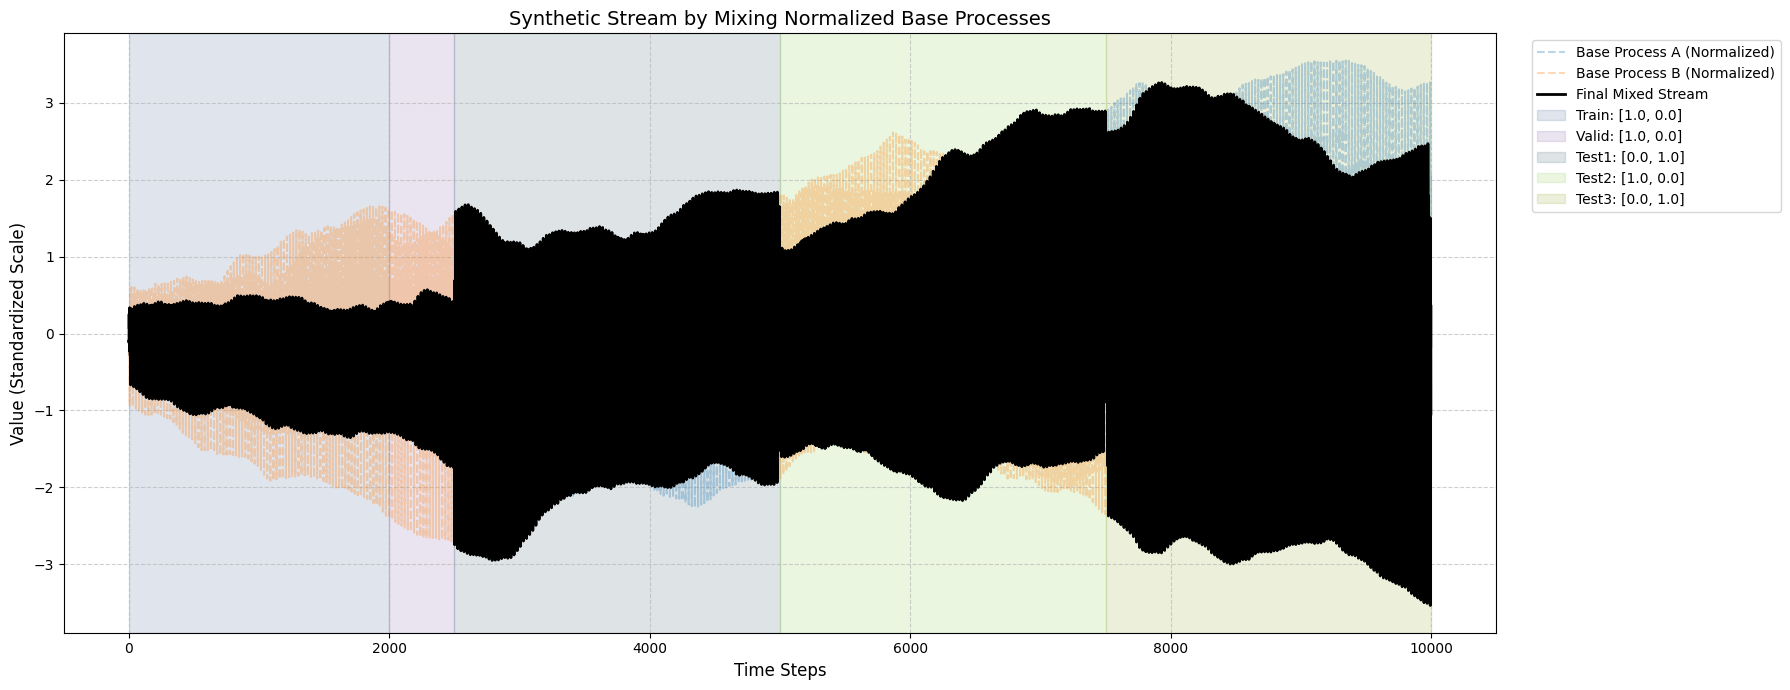

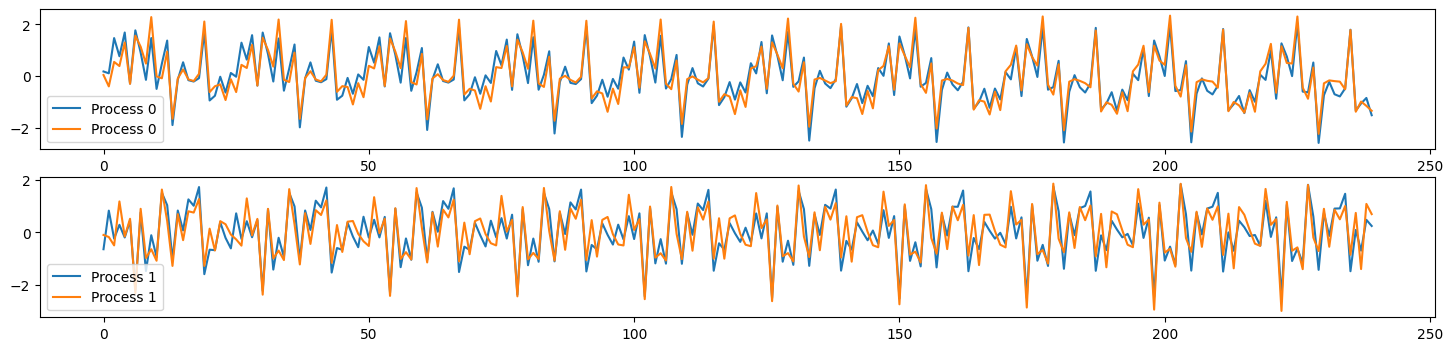

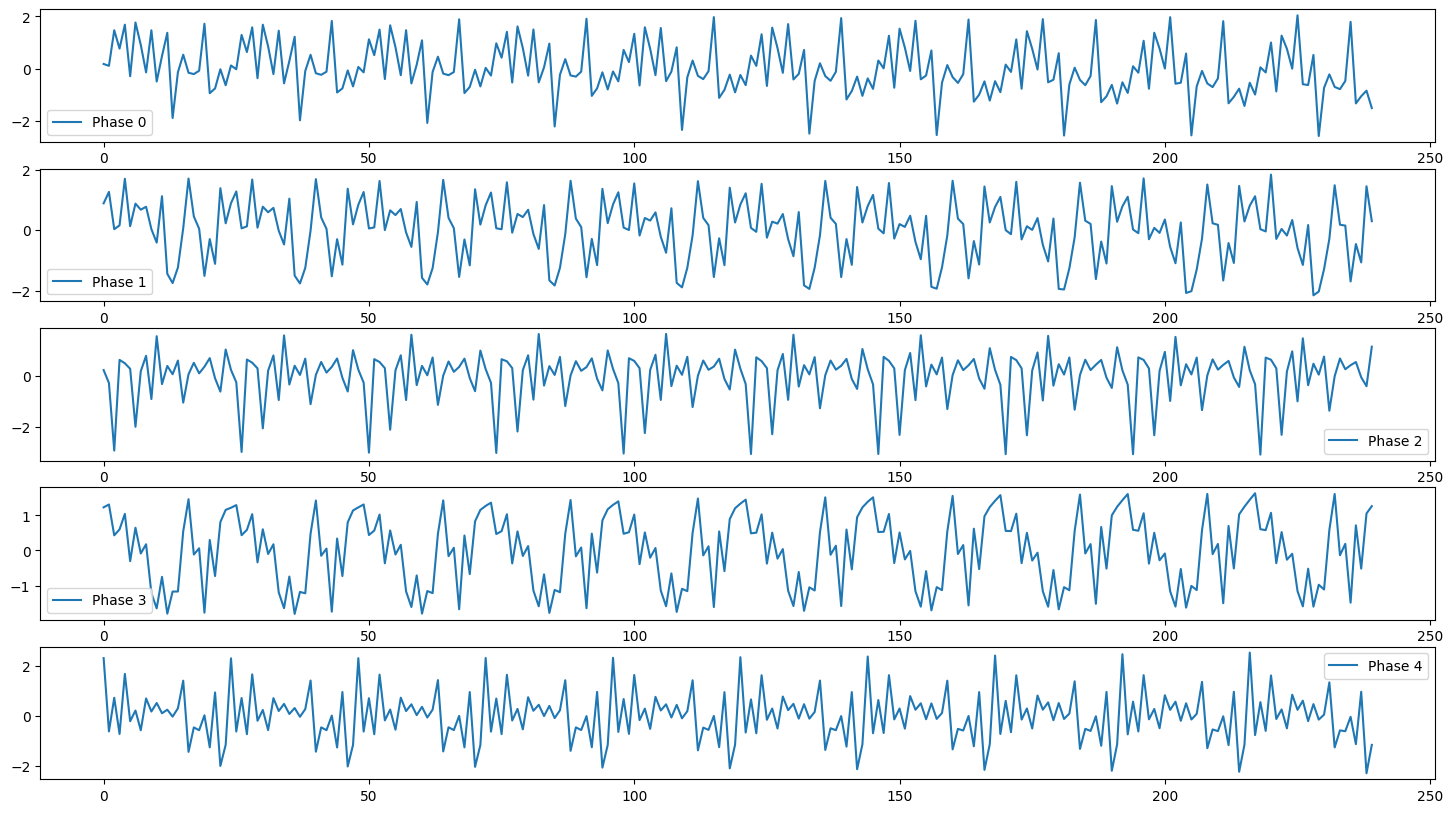

In [ ]:
# setting A
# ar_params = [0.7] -> [-0.2, -0.3]
setting = 'A3'
head_path = './dataset'
save_path = f'{head_path}/synthetic_{setting}.csv'

# ========== Definition of base processes ==========

# Process A
base_A = ProcessConfig(
	name="Process A",
	ar_params=[0.7],
	d=0,
	ma_params=[0.0],
	seasonal_ar_params=[0.8],
	D=1,
	s=24,
	noise_std=40
)

# Process B
base_B = ProcessConfig(
	name="Process B",
	ar_params=[-0.2, -0.3],
	d=0,
	ma_params=[0.0],
	seasonal_ar_params=[0.8],
	D=1,
	s=24,
	noise_std=40
)

# ========== Definition of mixing plan ==========
# Divide the data stream into 5 segments, and set different mixing ratios for each segment
# This simulates concept drift

num_dim = 10
total_length = 10000
ratio = [0.2, 0.05, 0.25, 0.25, 0.25]
train_length = int(total_length * ratio[0])
test1_length = int(total_length * ratio[2])
test2_length = int(total_length * ratio[3])
test3_length = int(total_length * ratio[4])
valid_length = total_length - train_length - test1_length - test2_length - test3_length
lengths = [train_length, valid_length, test1_length, test2_length, test3_length]

experiment_plan = [
	# Segment 1: Train
	MixingSegmentConfig( name="Train", length=lengths[0], weights=[1.0, 0.0]),
	# Segment 2: Valid
	MixingSegmentConfig( name="Valid", length=lengths[1], weights=[1.0, 0.0]),
	# Segment 3: Test1
	MixingSegmentConfig( name="Test1", length=lengths[2], weights=[0.0, 1.0]),
	# Segment 4: Test2
	MixingSegmentConfig( name="Test2", length=lengths[3], weights=[1.0, 0.0]),
	# Segment 5: Test3
	MixingSegmentConfig( name="Test3", length=lengths[4], weights=[0.0, 1.0]),
]

# ========== Run data generation ==========
print("=" * 70)
print("Starting synthetic data stream generation...")
print("=" * 70)

final_stream, normalized_base_A, normalized_base_B = [], [], []
for i in range(num_dim):
	stream, normalized_base = create_mixed_stream(
		base_configs=[base_A, base_B],
		mixing_plan=experiment_plan
	)
	final_stream.append(stream)
	normalized_base_A.append(normalized_base[0])
	normalized_base_B.append(normalized_base[1])
final_stream = np.stack(final_stream, axis=1) # (total_length, num_dim)
normalized_base_A = np.stack(normalized_base_A, axis=1) # (total_length, num_dim)
normalized_base_B = np.stack(normalized_base_B, axis=1) # (total_length, num_dim)
normalized_bases = np.stack([normalized_base_A, normalized_base_B], axis=0) # (2, total_length, num_dim)


print("=" * 70)
print("Generation complete! Plotting results...")
print("=" * 70)

# ========== Visualize results ==========
plot_mixed_stream(final_stream[:, -1], normalized_bases[:, :, -1], experiment_plan)

plot_bases(normalized_bases[:, :, -1], s=24)

plot_phase(final_stream[:, -1], lengths, s=24)

df = pd.DataFrame(final_stream, columns=[f'value_{i}' for i in range(num_dim)])
df.to_csv(save_path, index=False)

Starting synthetic data stream generation...
Generating base time series...
  - Generated base series 'Process A' (length=10000)
  - Generated base series 'Process B' (length=10000)

Normalizing base series (mean=0, std=1)...
  - Normalized series 0: mean=512.967, std=3895.689
  - Normalized series 1: mean=-6785.684, std=4992.086

Mixing normalized segments according to the plan...
  - Created segment 'Train' (length=2000, weights=[1.0, 0.0])
  - Created segment 'Valid' (length=500, weights=[1.0, 0.0])
  - Created segment 'Test1' (length=2500, weights=[0.0, 1.0])
  - Created segment 'Test2' (length=2500, weights=[1.0, 0.0])
  - Created segment 'Test3' (length=2500, weights=[0.0, 1.0])

Final stream created: total length = 10000
Generating base time series...
  - Generated base series 'Process A' (length=10000)
  - Generated base series 'Process B' (length=10000)

Normalizing base series (mean=0, std=1)...
  - Normalized series 0: mean=-57.786, std=5518.315
  - Normalized series 1: mean

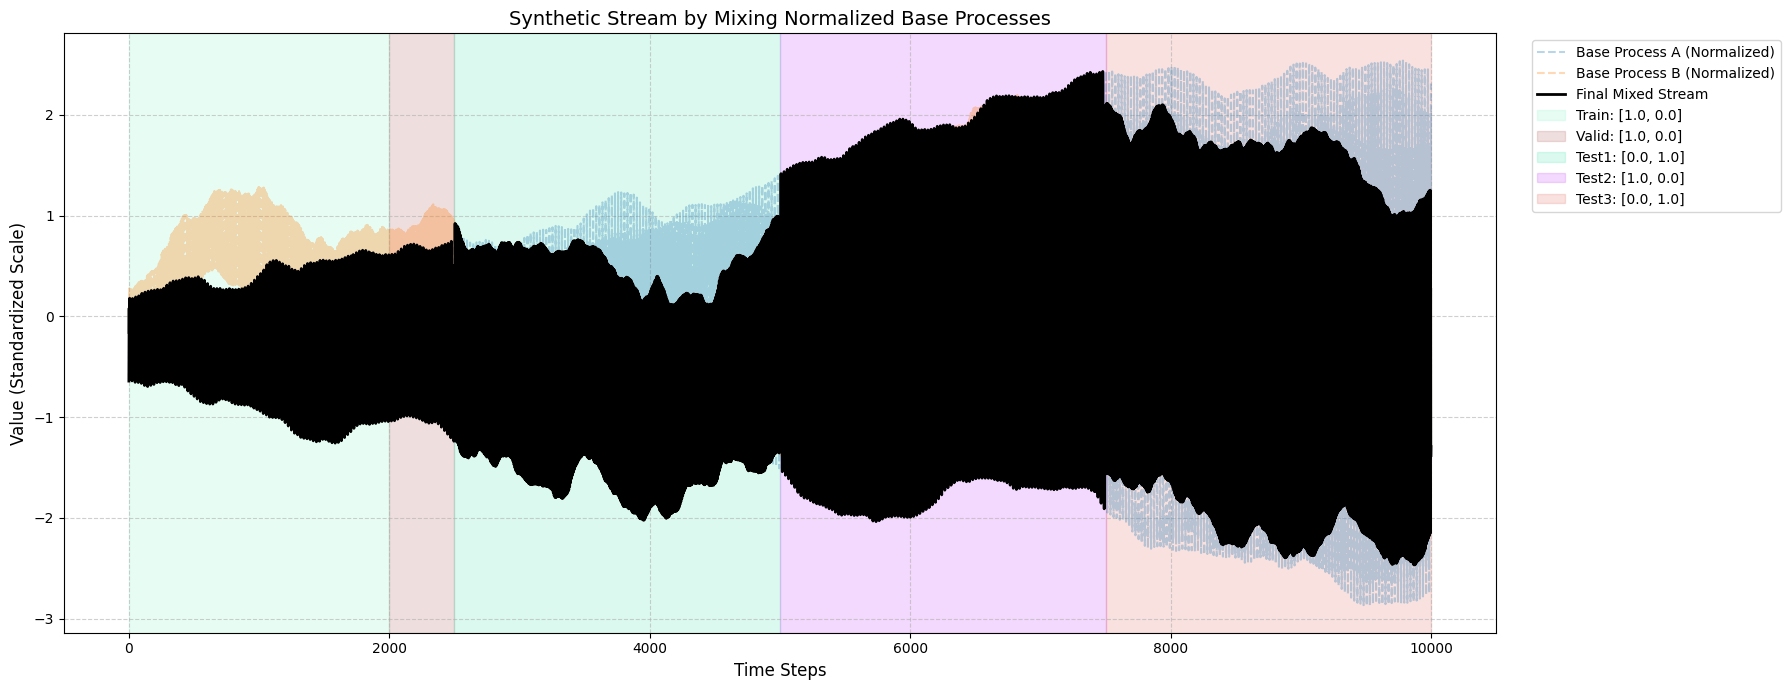

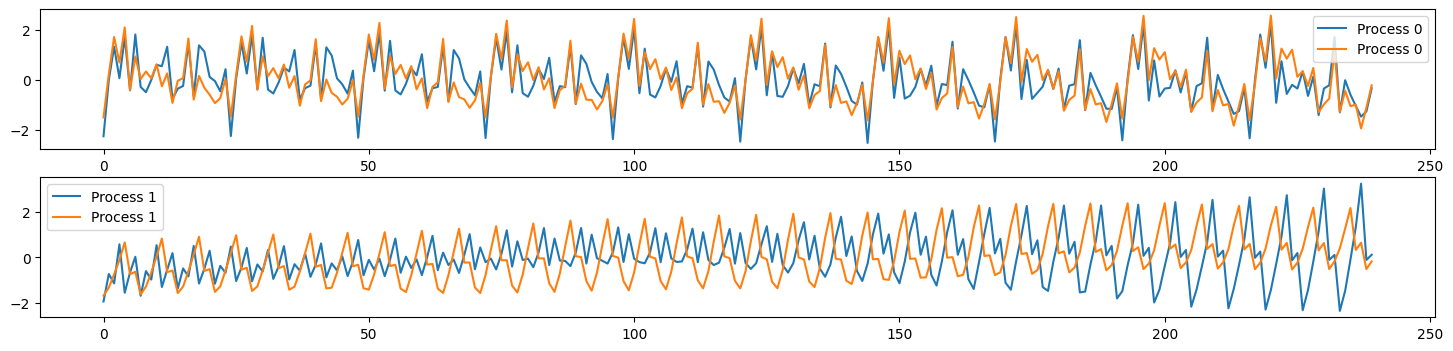

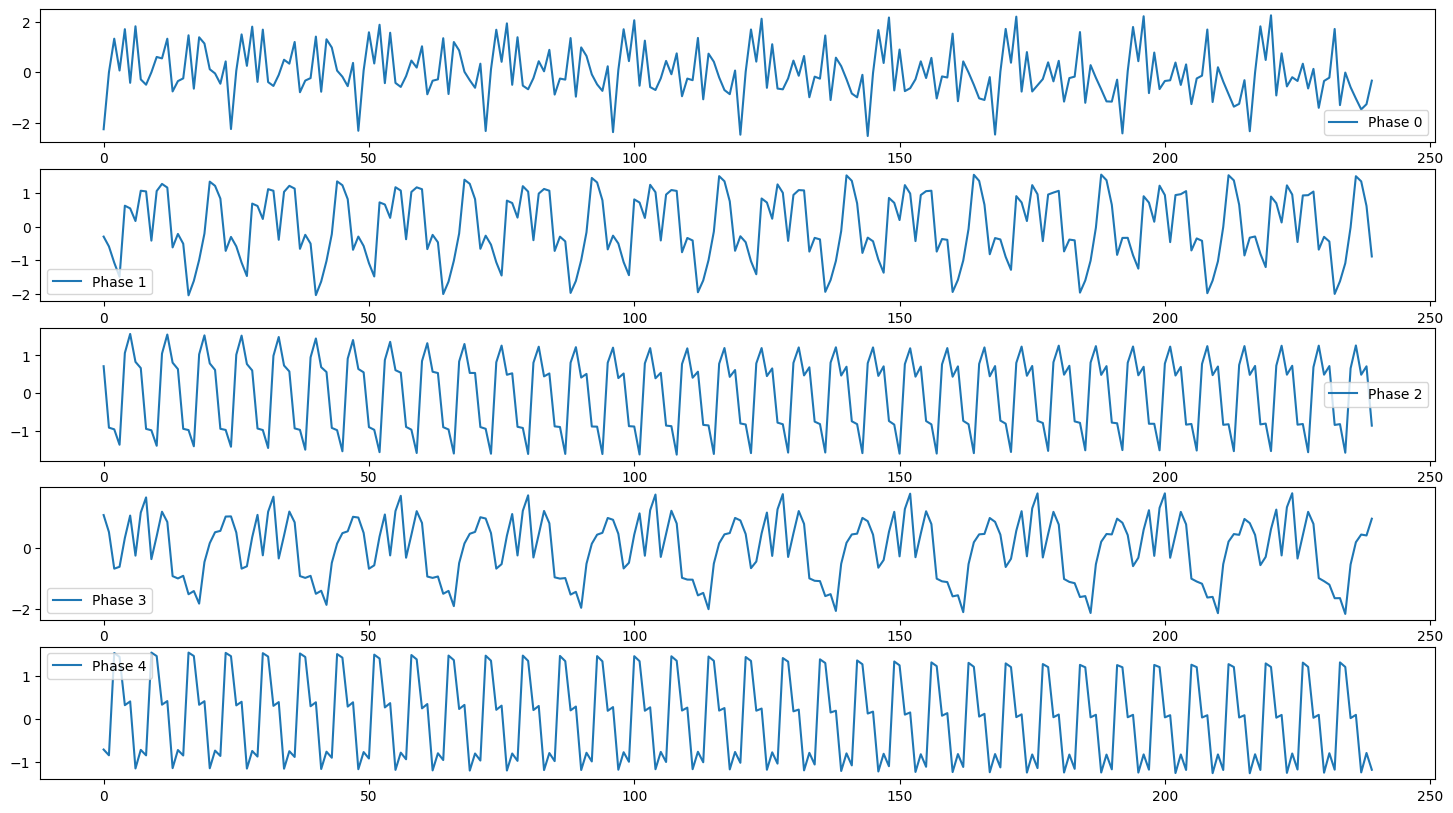

In [ ]:
# setting B
# s = 24 -> 7
setting = 'B3'
head_path = './dataset'
save_path = f'{head_path}/synthetic_{setting}.csv'

# ========== Fix random seed ==========
# For reproducibility, fix the random seed of the random number generator
# If the same seed is used, the same data is generated every time
np.random.seed(42)

# ========== Define base processes ==========

# Process A
base_A = ProcessConfig(
	name="Process A",
	ar_params=[0.6],
	d=0,
	ma_params=[0.2],
	seasonal_ar_params=[0.8],
	D=1,
	s=24,
	noise_std=40
)

# Process B
base_B = ProcessConfig(
	name="Process B",
	ar_params=[0.6],
	d=0,
	ma_params=[0.2],
	seasonal_ar_params=[0.8],
	D=1,
	s=7,
	noise_std=40
)

# ========== Definition of mixing plan ==========
# Divide the data stream into 5 segments, and set different mixing ratios for each segment
# This simulates concept drift

num_dim = 10
total_length = 10000
ratio = [0.2, 0.05, 0.25, 0.25, 0.25]
train_length = int(total_length * ratio[0])
test1_length = int(total_length * ratio[2])
test2_length = int(total_length * ratio[3])
test3_length = int(total_length * ratio[4])
valid_length = total_length - train_length - test1_length - test2_length - test3_length
lengths = [train_length, valid_length, test1_length, test2_length, test3_length]

experiment_plan = [
	# Segment 1: Train
	MixingSegmentConfig( name="Train", length=lengths[0], weights=[1.0, 0.0]),
	# Segment 2: Valid
	MixingSegmentConfig( name="Valid", length=lengths[1], weights=[1.0, 0.0]),
	# Segment 3: Test1
	MixingSegmentConfig( name="Test1", length=lengths[2], weights=[0.0, 1.0]),
	# Segment 4: Test2
	MixingSegmentConfig( name="Test2", length=lengths[3], weights=[1.0, 0.0]),
	# Segment 5: Test3
	MixingSegmentConfig( name="Test3", length=lengths[4], weights=[0.0, 1.0]),
]

# ========== Run data generation ==========
print("=" * 70)
print("Starting synthetic data stream generation...")
print("=" * 70)

final_stream, normalized_base_A, normalized_base_B = [], [], []
for i in range(num_dim):
	stream, normalized_base = create_mixed_stream(
		base_configs=[base_A, base_B],
		mixing_plan=experiment_plan
	)
	final_stream.append(stream)
	normalized_base_A.append(normalized_base[0])
	normalized_base_B.append(normalized_base[1])
final_stream = np.stack(final_stream, axis=1) # (total_length, num_dim)
normalized_base_A = np.stack(normalized_base_A, axis=1) # (total_length, num_dim)
normalized_base_B = np.stack(normalized_base_B, axis=1) # (total_length, num_dim)
normalized_bases = np.stack([normalized_base_A, normalized_base_B], axis=0) # (2, total_length, num_dim)


print("=" * 70)
print("Generation complete! Plotting results...")
print("=" * 70)

# ========== Visualize results ==========
plot_mixed_stream(final_stream[:, -1], normalized_bases[:, :, -1], experiment_plan)

plot_bases(normalized_bases[:, :, -1], s=24)

plot_phase(final_stream[:, -1], lengths, s=24)

df = pd.DataFrame(final_stream, columns=[f'value_{i}' for i in range(num_dim)])
df.to_csv(save_path, index=False)